In [24]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import json
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
import tb_gene_signature_pipeline.network_analysis as na
import tb_gene_signature_pipeline.plotting as tbplt

In [26]:
project_dir = Path.cwd().resolve().parent

In [27]:
with (project_dir / 'data' / 'datasets.json').open('r') as f:
    datasets = json.load(f)

In [28]:
with (project_dir / 'data' / 'comparisons.json').open('r') as f:
    comparisons = json.load(f)

In [29]:
with (project_dir / 'config.yml').open('r') as f:
    config = yaml.safe_load(f)

### Differential Expression Analysis

Generate per-gene differential expression statistics for each dataset and for each case/control group comparison.

In [31]:
differential_expression_results = na.run_differential_expression_analysis(
    log_transform_all_geo_data=False, quantile_normalize_per_class=False,
    salmon_or_rsem='salmon', overwrite=True)

#### Sample expression distributions by dataset

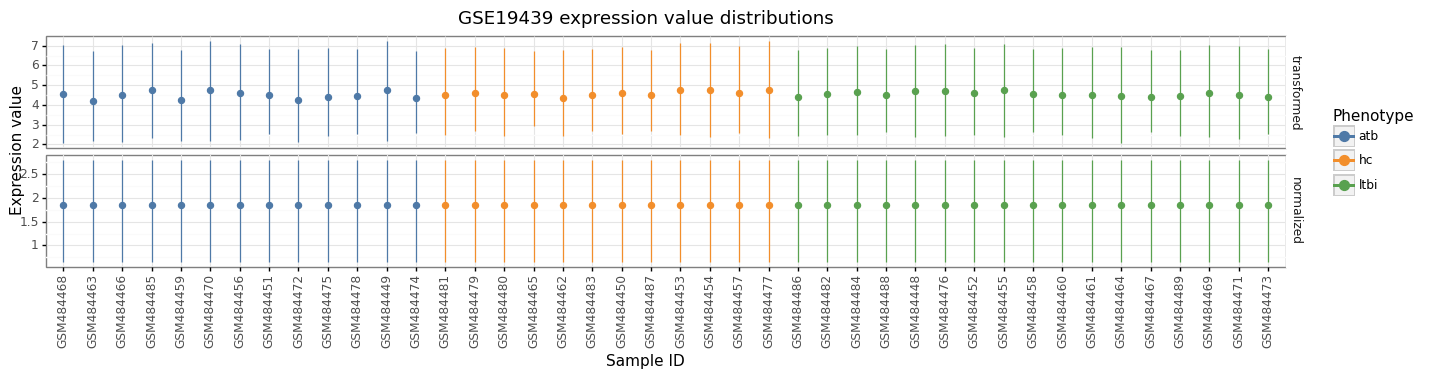

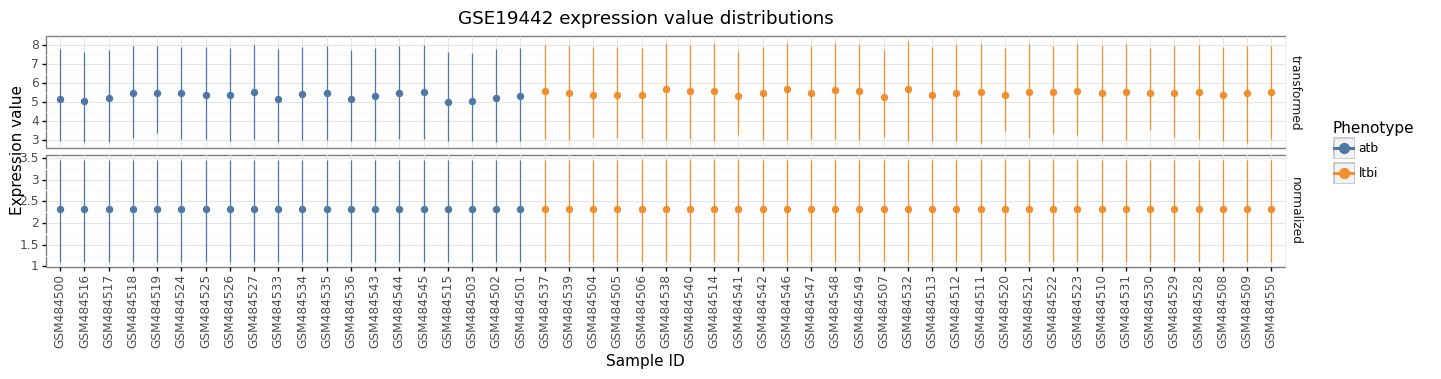

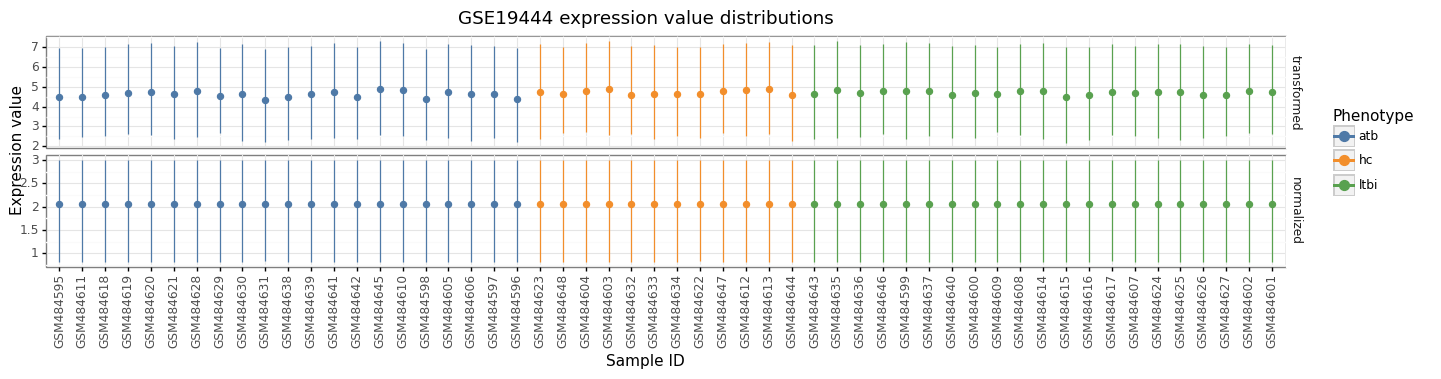

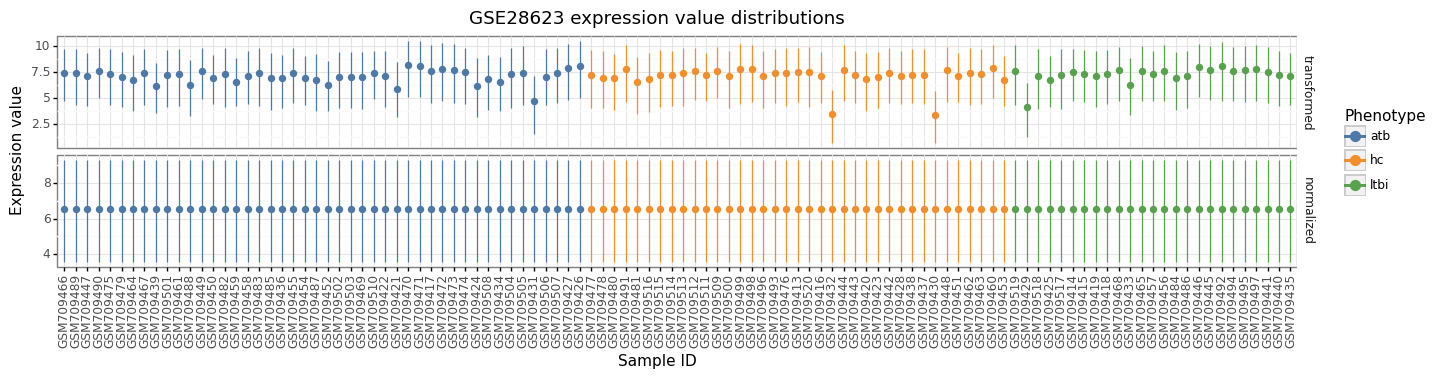

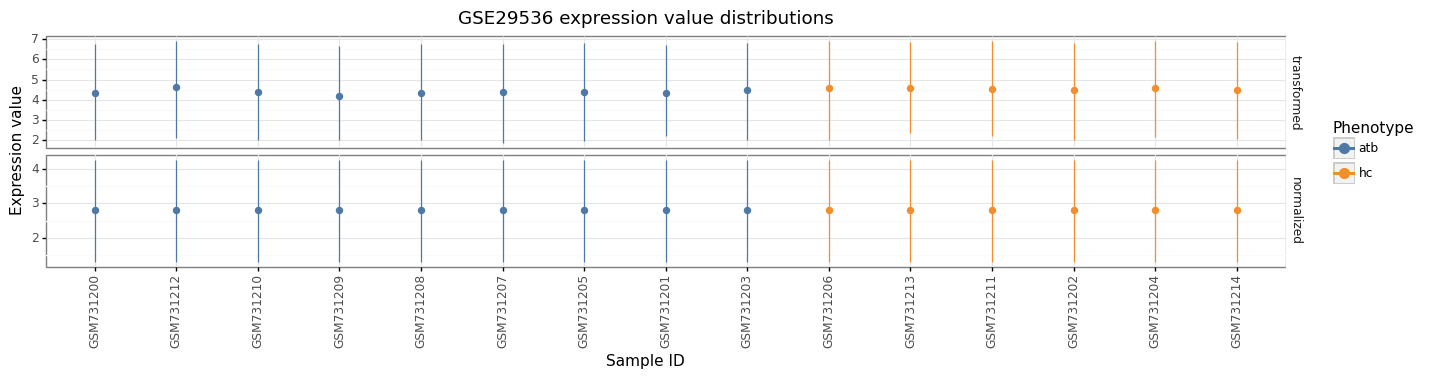

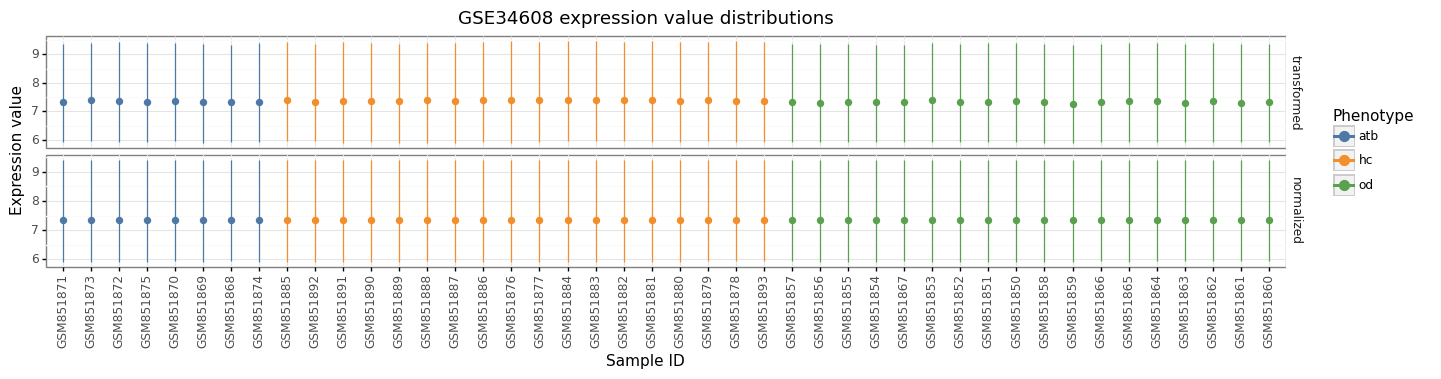

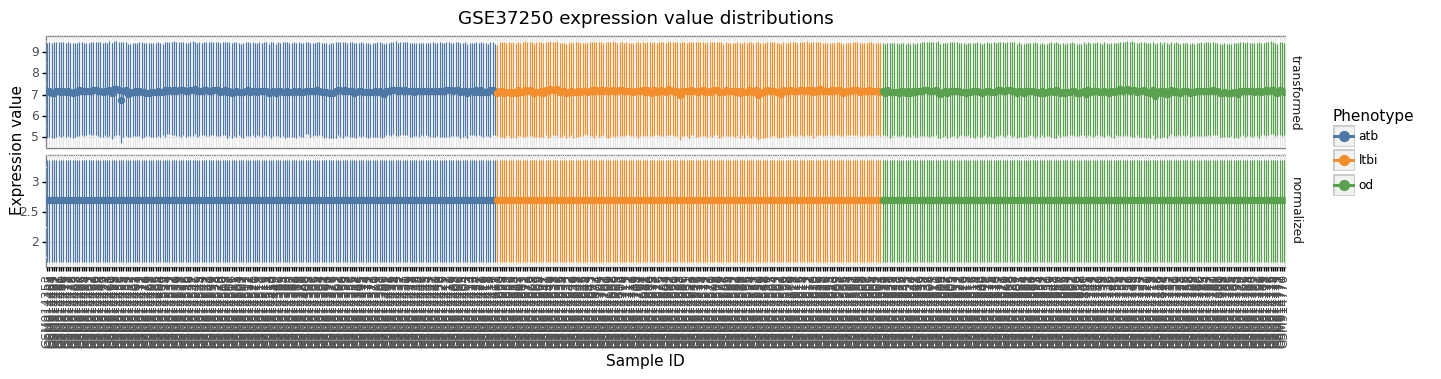

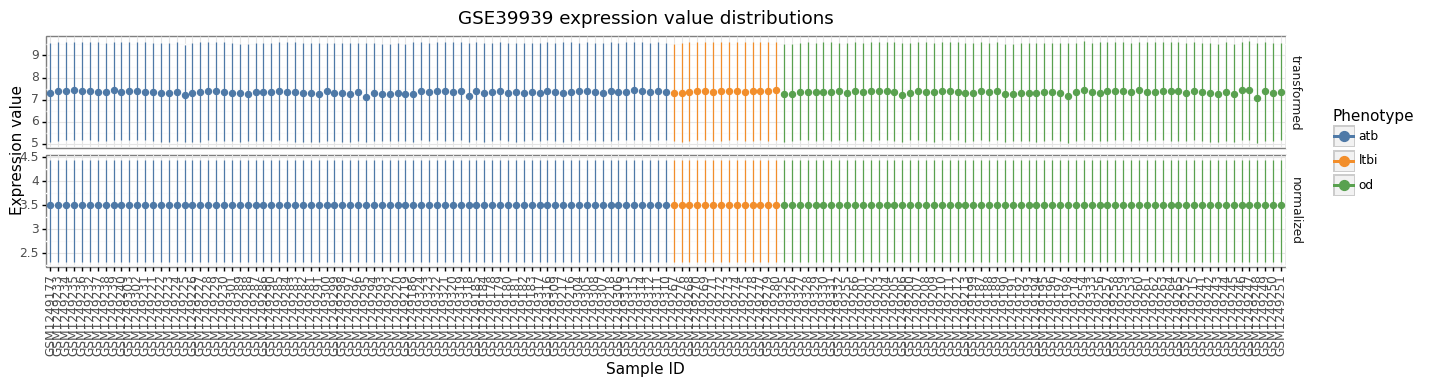

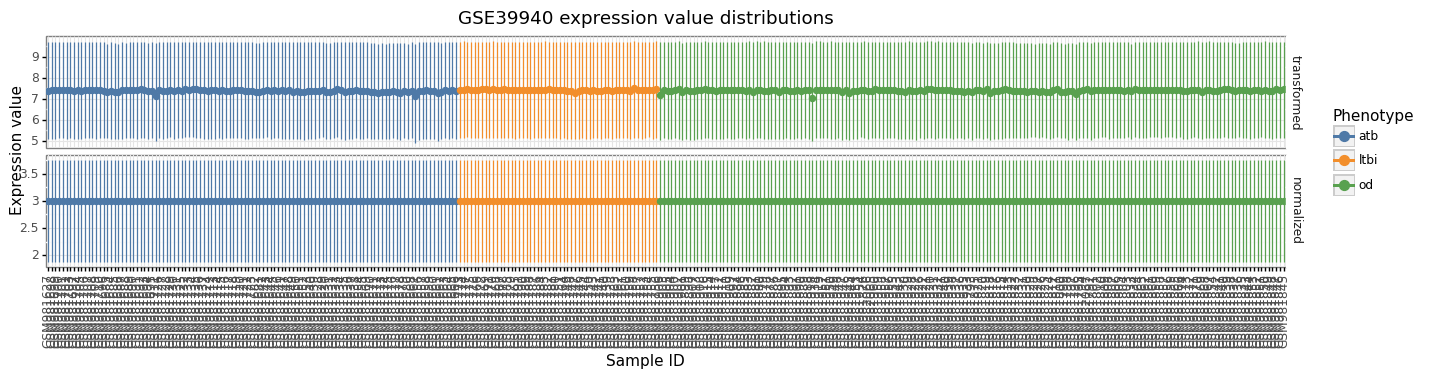

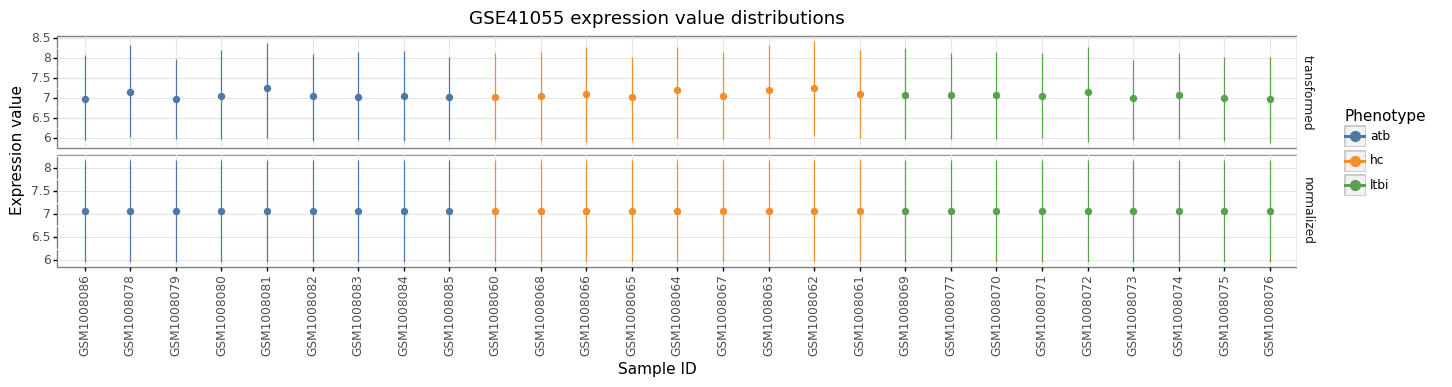

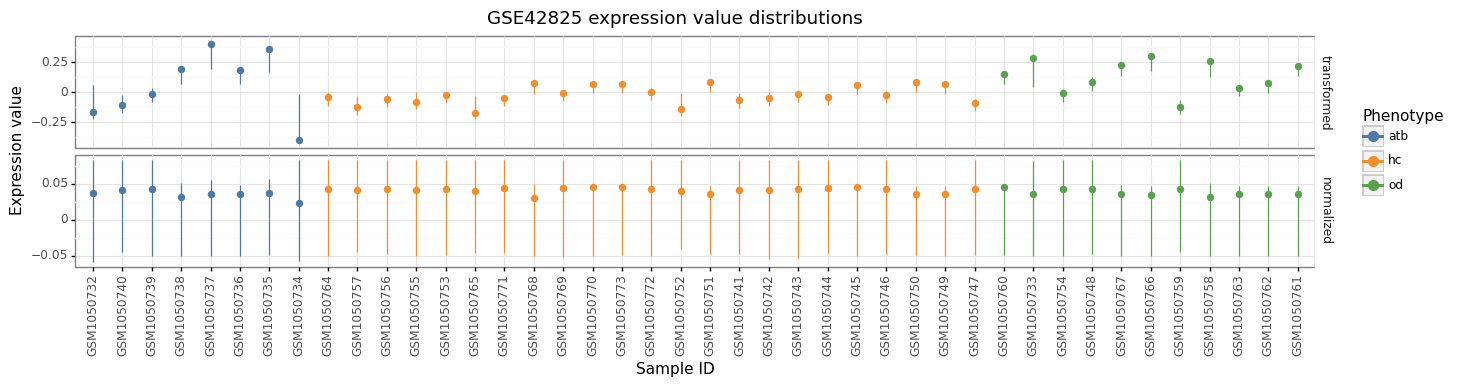

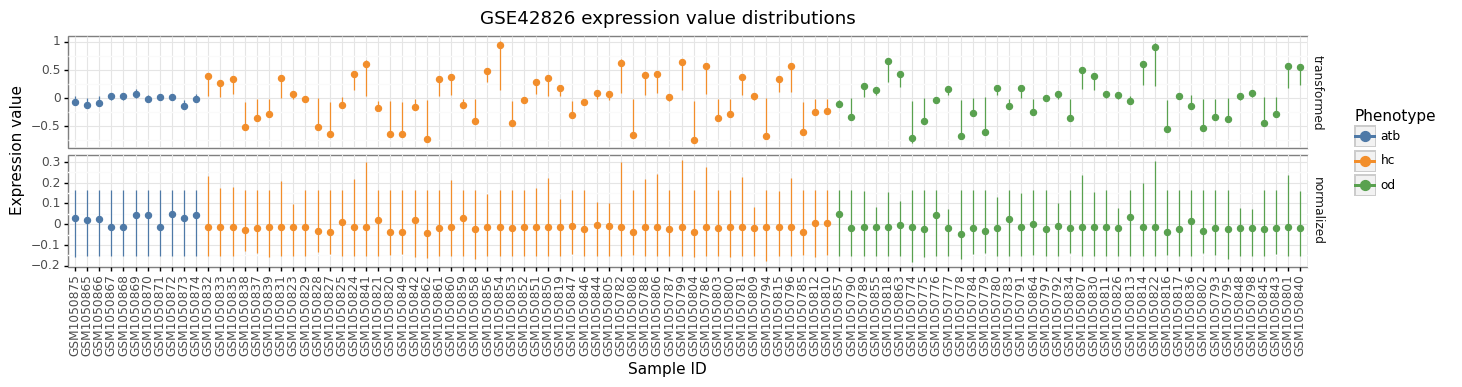

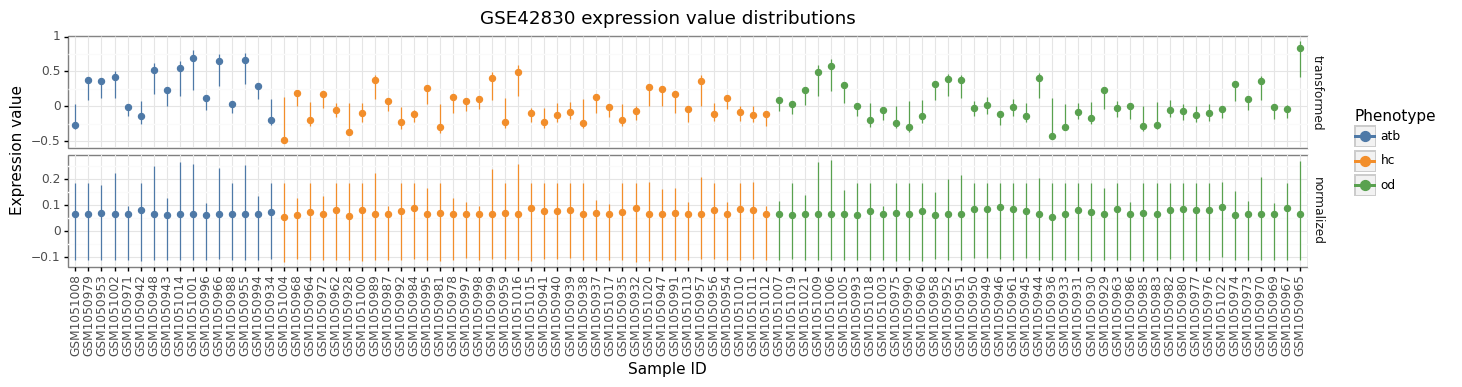

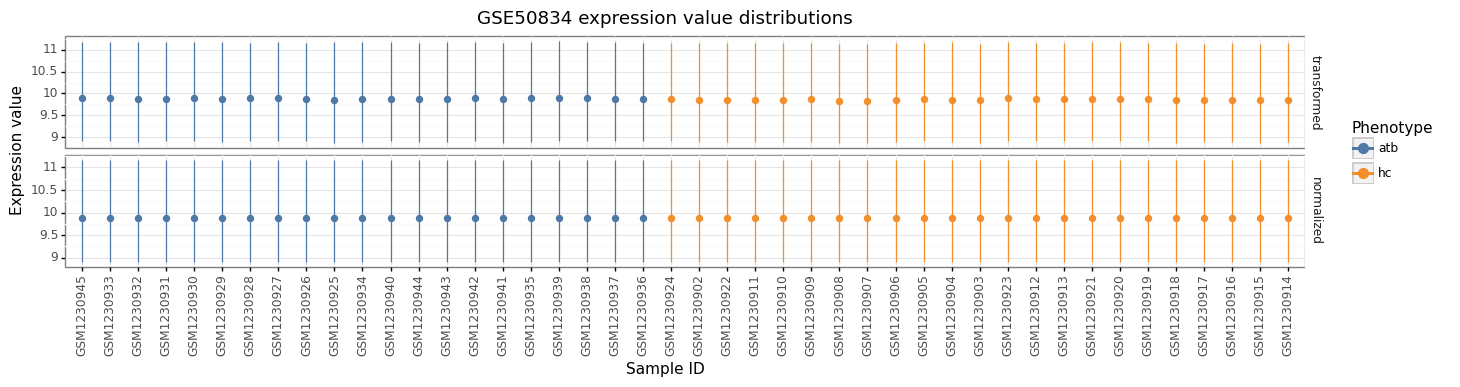

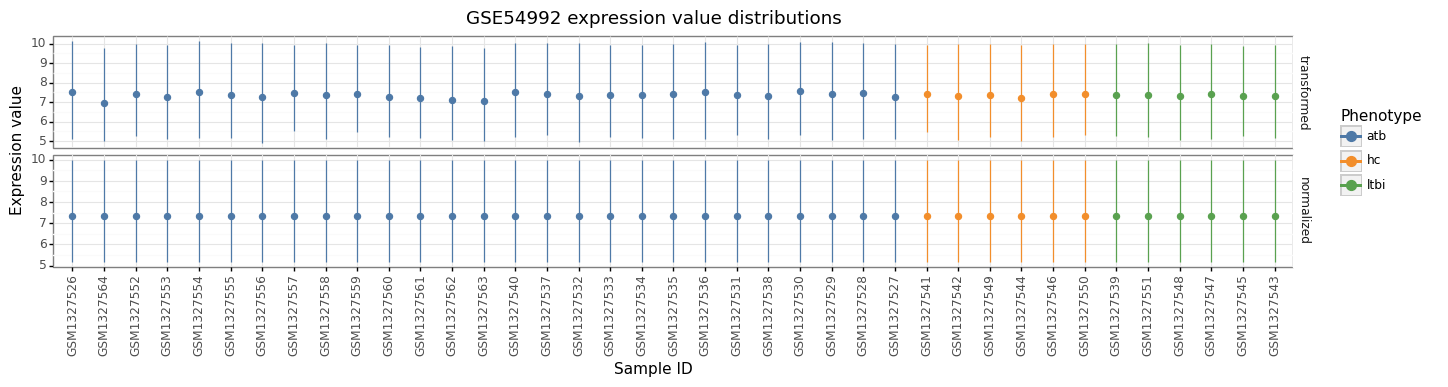

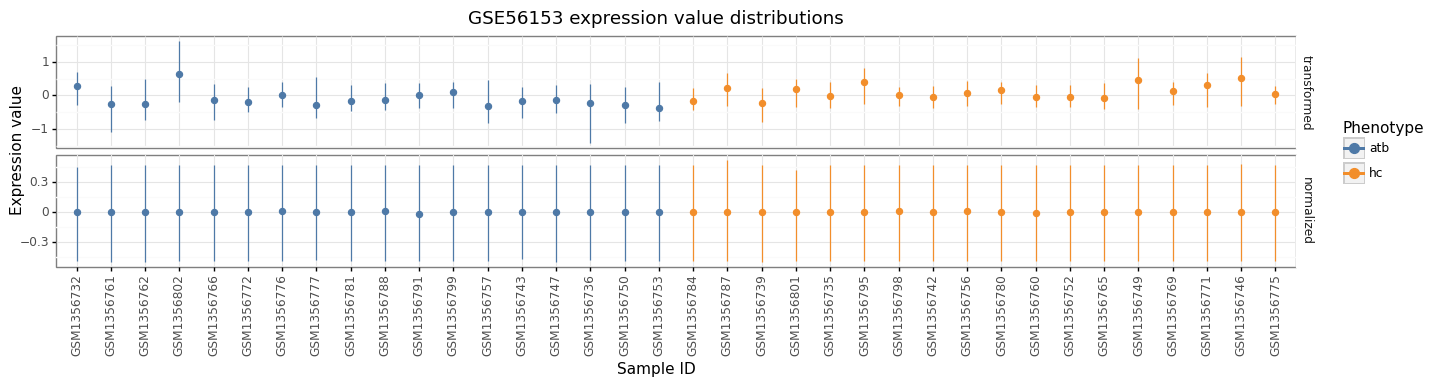

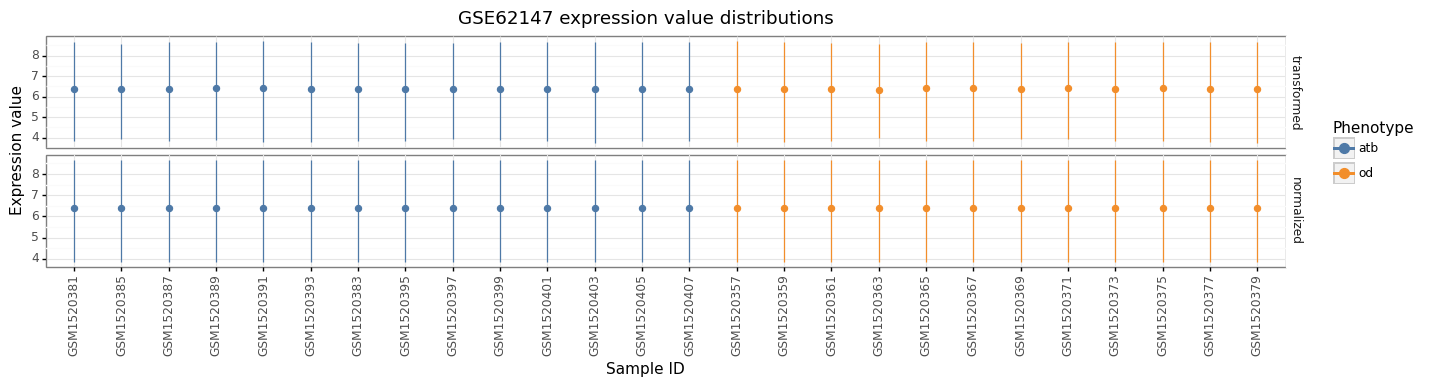

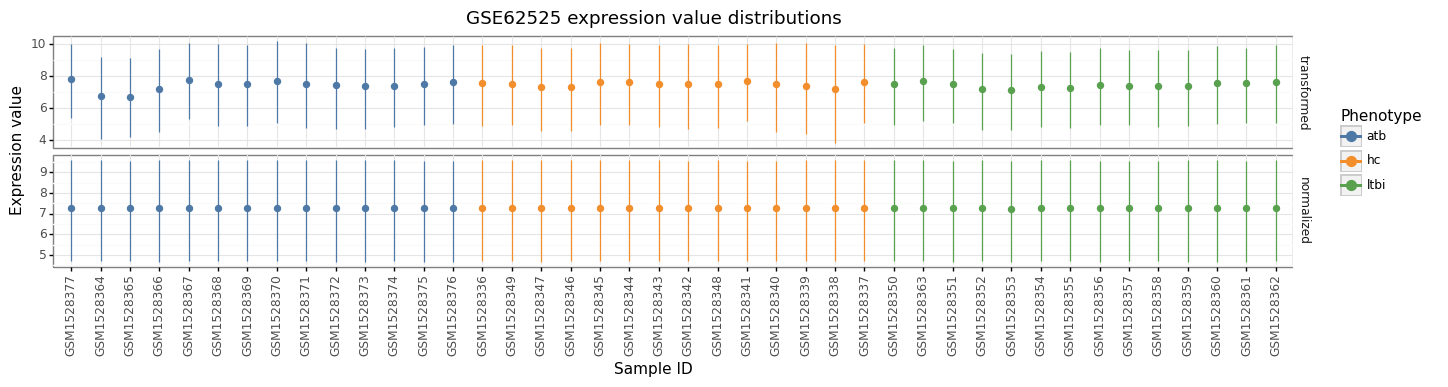

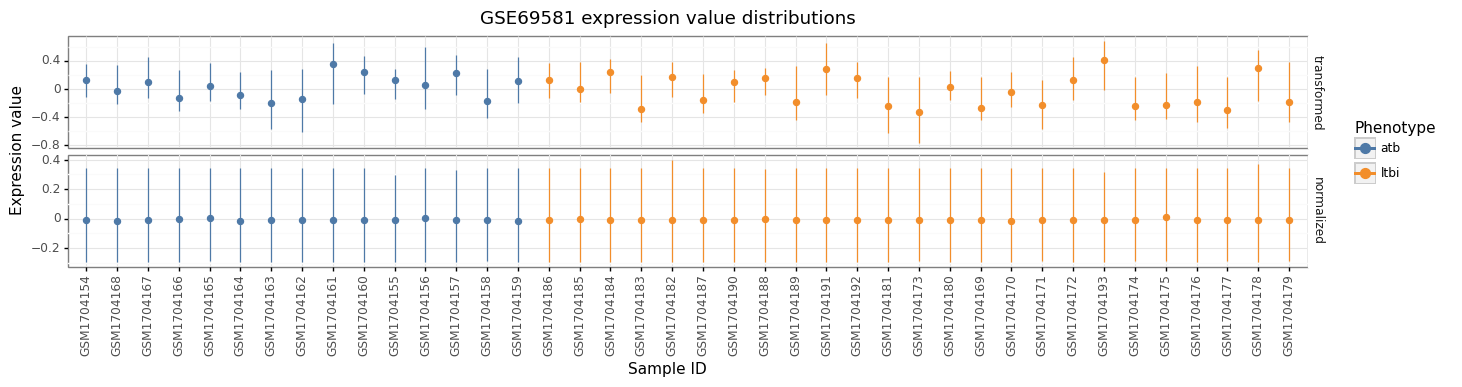

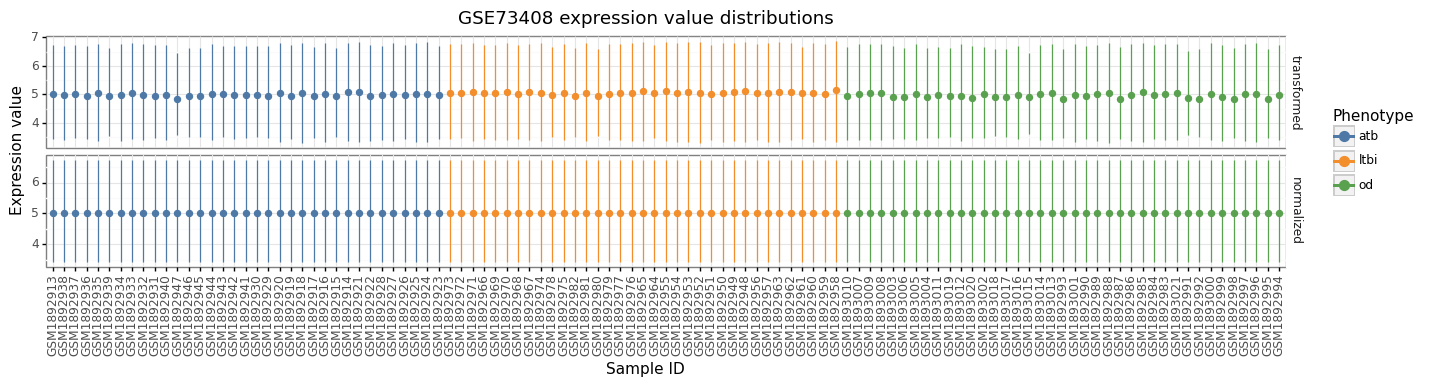

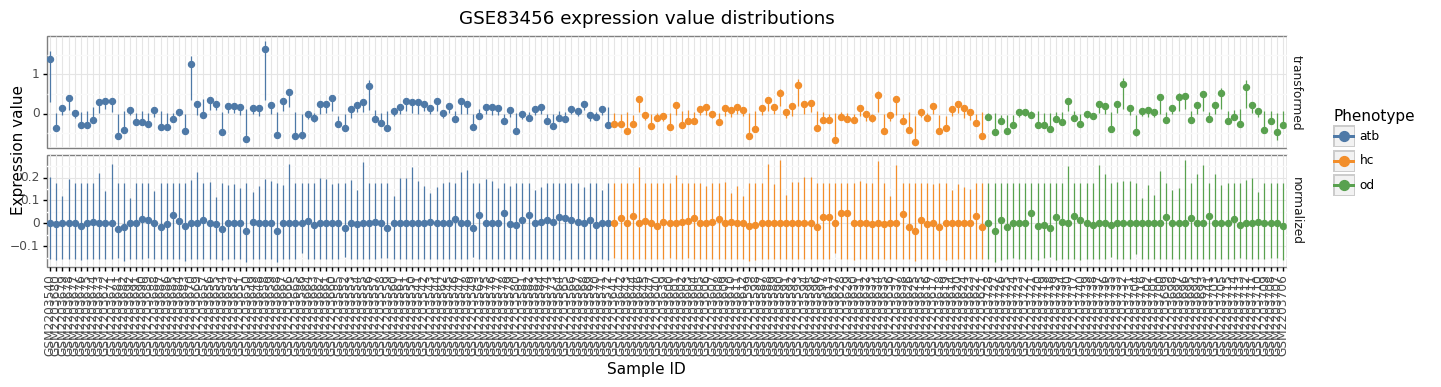

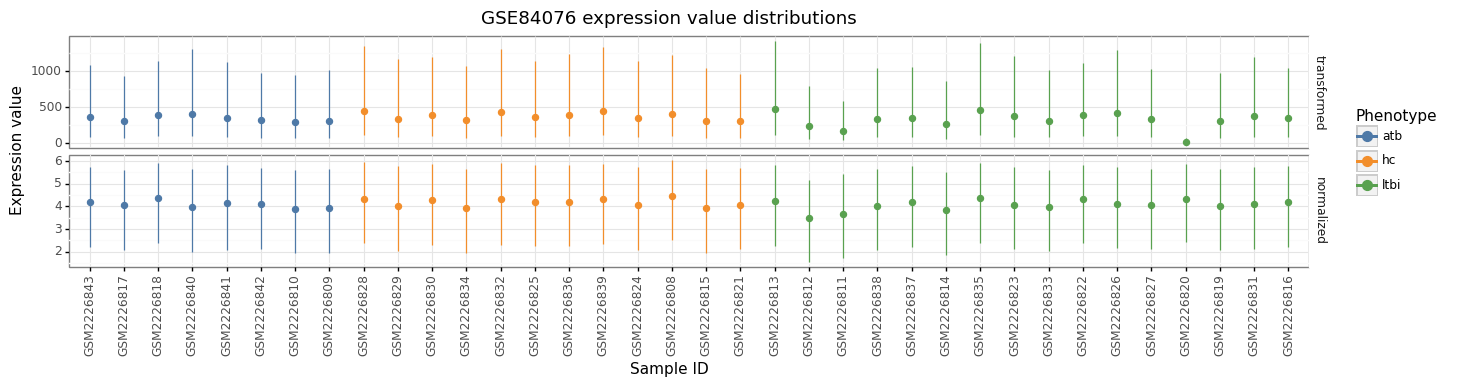

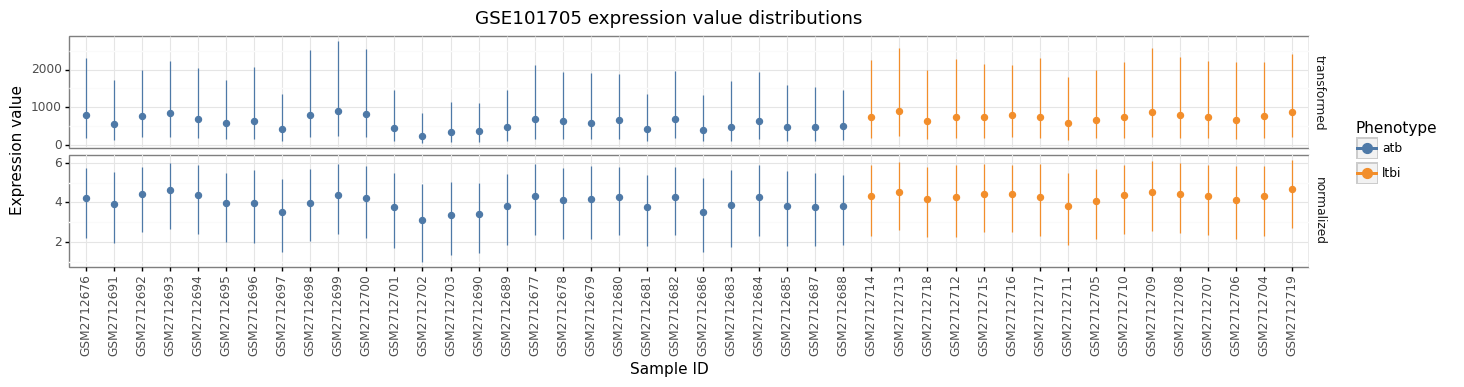

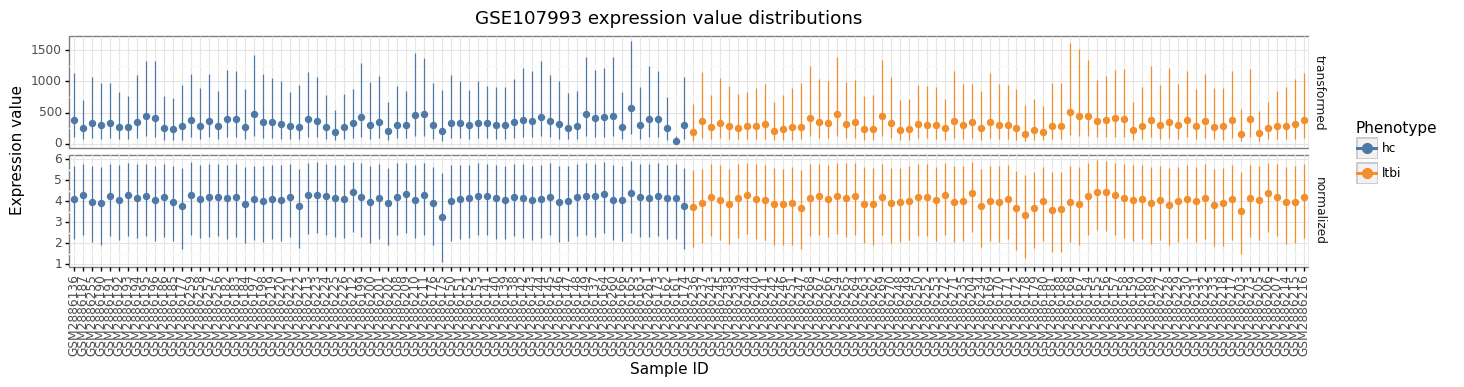

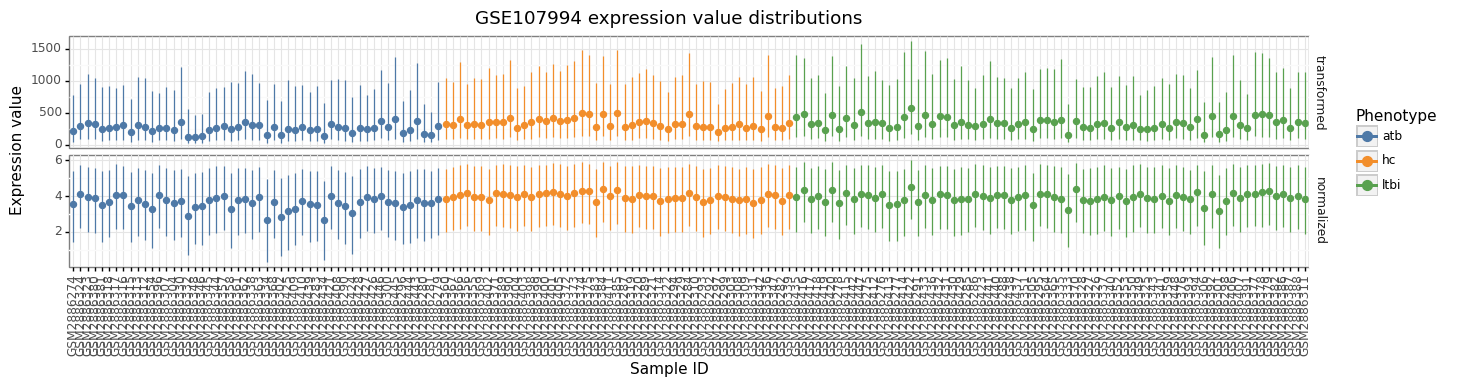

In [32]:
for dataset in datasets:
    tbplt.plot_expression_distributions(
        differential_expression_results['exprs'], gse_id=dataset['gse_id']).draw();

### Merge Differential Expression Results

Given differential expression statistics across datasets and comparisons, filter the results to include
only genes with `adj_p_val <= 0.05` and effect size `log_fc >= np.log2(1.5)`. Combine filtered log fold
change effect sizes into a ``(gene * n_comparisons)-by-dataset`` dataframe.

In [33]:
merged_results = na.merge_differential_expression_results(
    differential_expression_results['results'], adj_pval_thresh=0.05, log_fc_thresh=np.log2(1.5))

#### Plot distribution of number of datasets in which each gene is significantly differentially expressed

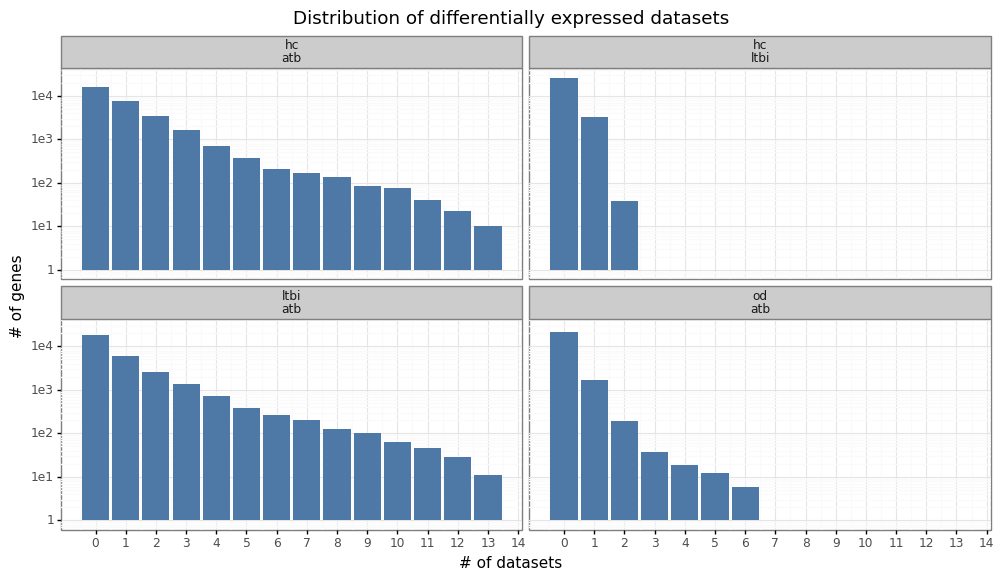

In [34]:
tbplt.plot_n_datasets_differentially_expressed(merged_results).draw();

#### Plot edge weight distributions

In [35]:
edge_weight_distributions = na.compute_edge_weight_distributions(merged_results, overwrite=True)

In [36]:
null_edge_weight_distributions = na.generate_null_edge_weight_distributions(merged_results, n_iter=5, overwrite=True)

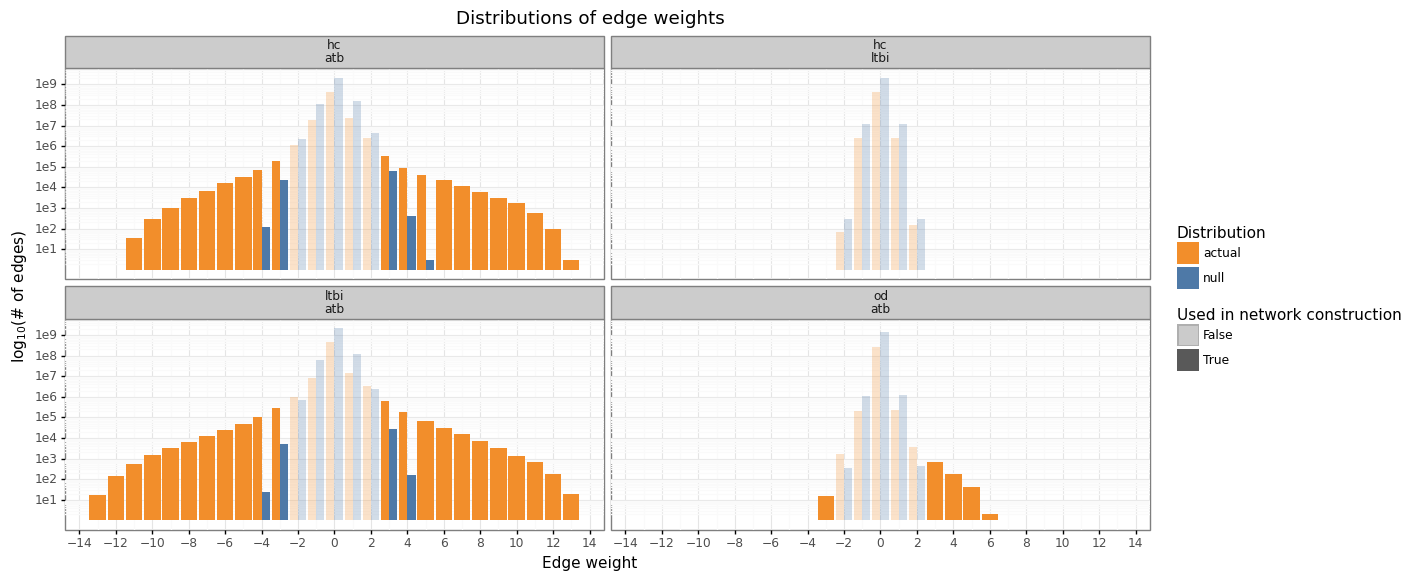

In [37]:
tbplt.plot_edge_weight_distributions(
    edge_weight_distributions, null_edge_weight_distributions).draw();

### Construct gene effect network

Use the signficant log fold change effect size estimates to construct a network where nodes correspond to genes
and an edge between two nodes represents significant differential expression for each of the two genes in the
same direction (positive or negative) in **at least 3 datasets**.

A separate network is constructed for each comparison group (`hc` vs. `atb`, etc.).

Also computes degree, weighted degree, and eigenvector centrality measures for each node in the networks.

In [38]:
networks = na.construct_networks(merged_results, overwrite=True)

#### Plot node measures

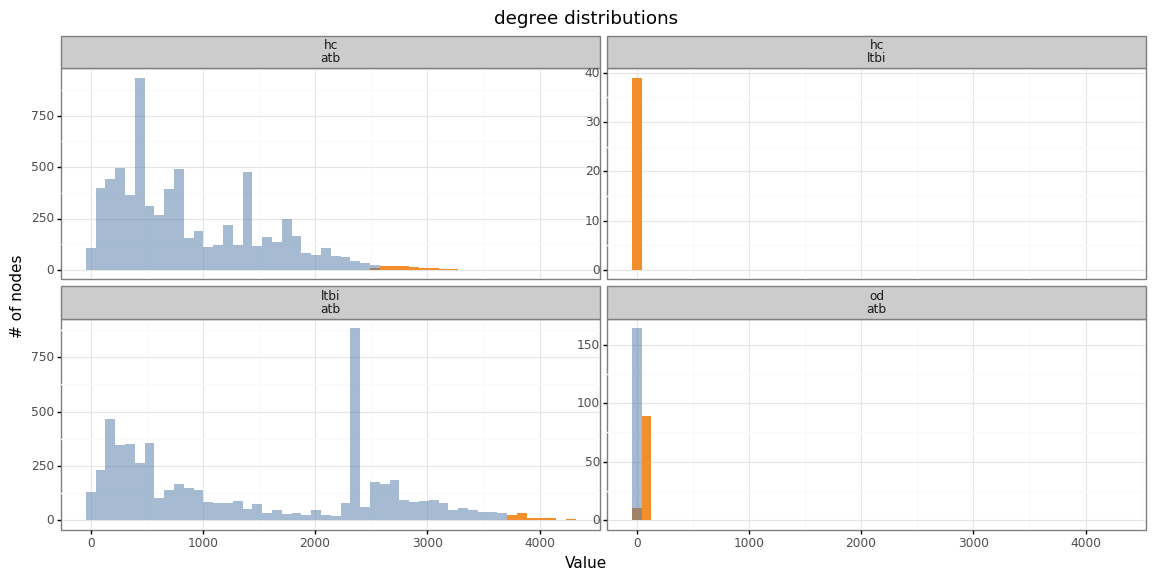

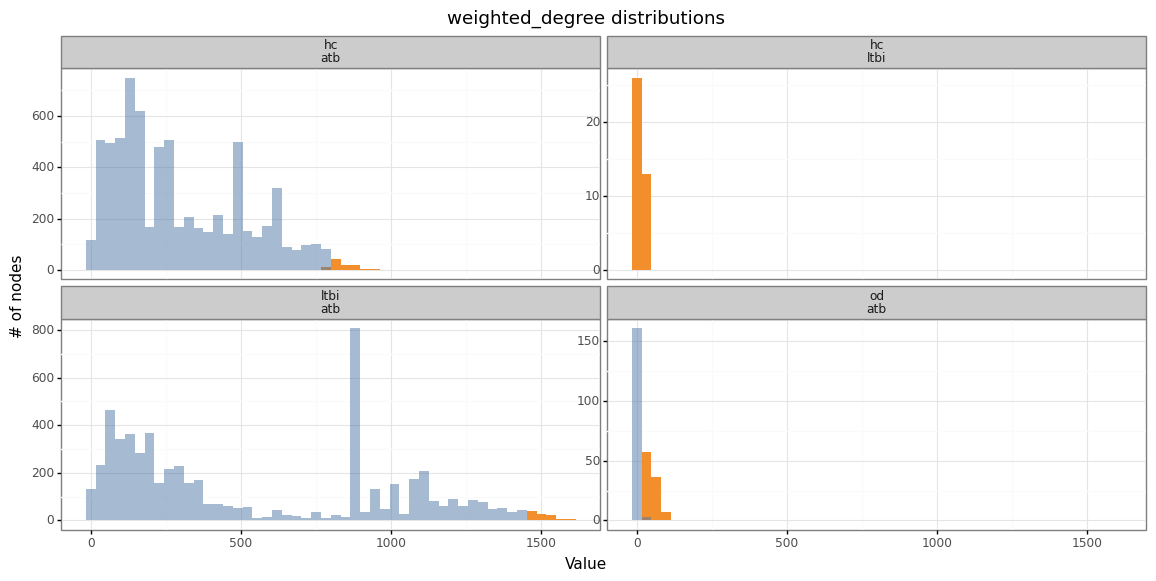

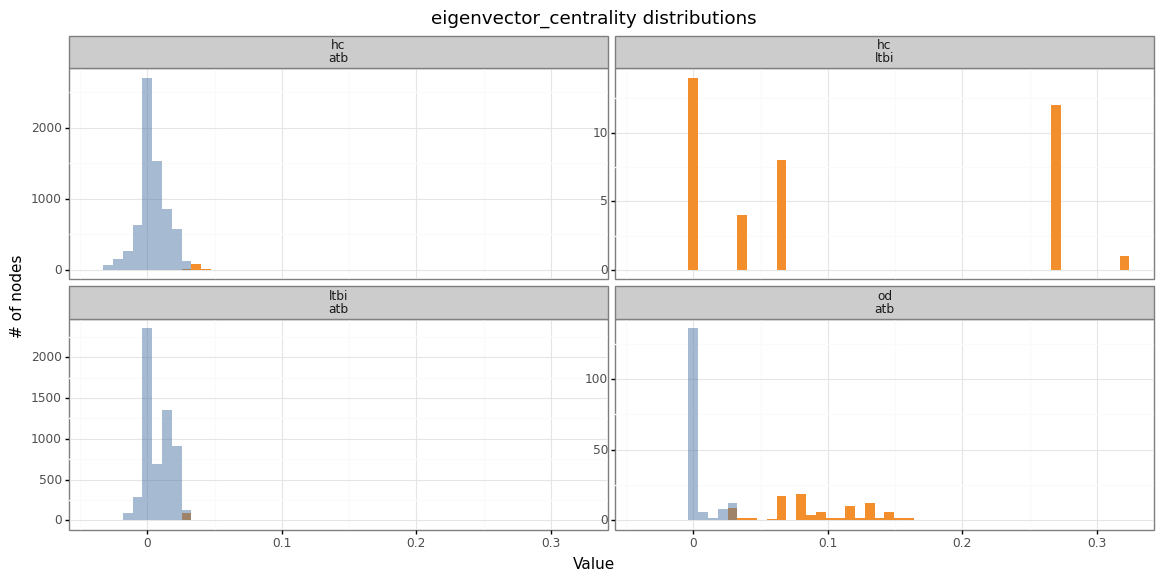

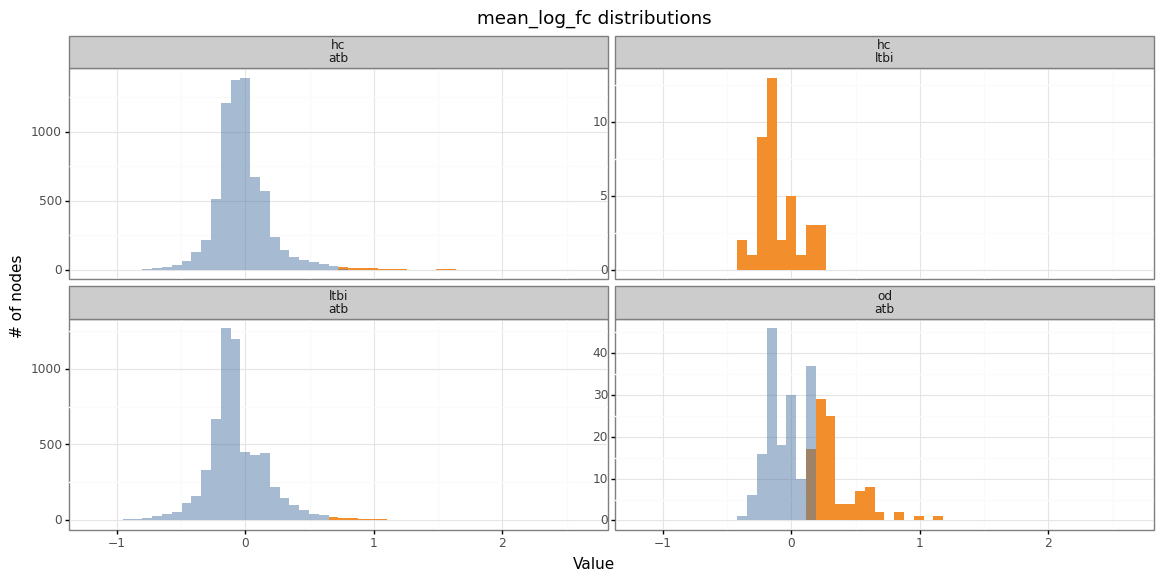

In [39]:
for measure in ['degree', 'weighted_degree', 'eigenvector_centrality', 'mean_log_fc']:
    tbplt.plot_node_measure_distributions(networks, measure=measure, top_n=100).draw();

#### Plot mean log FC vs. node centrality measures

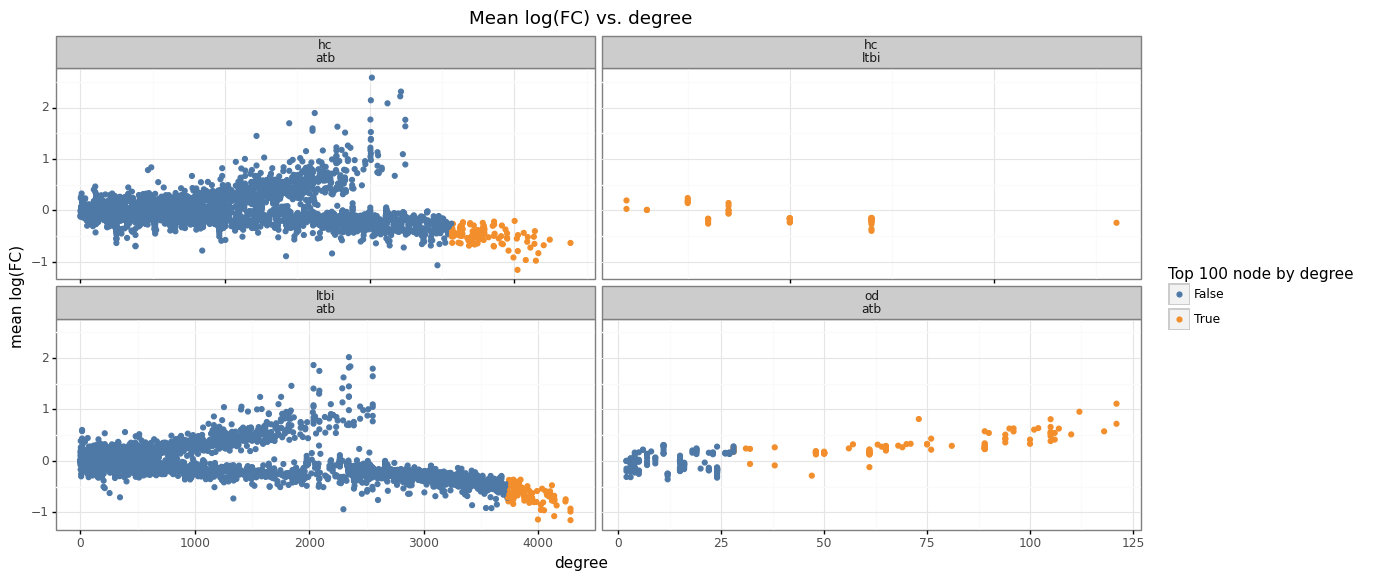

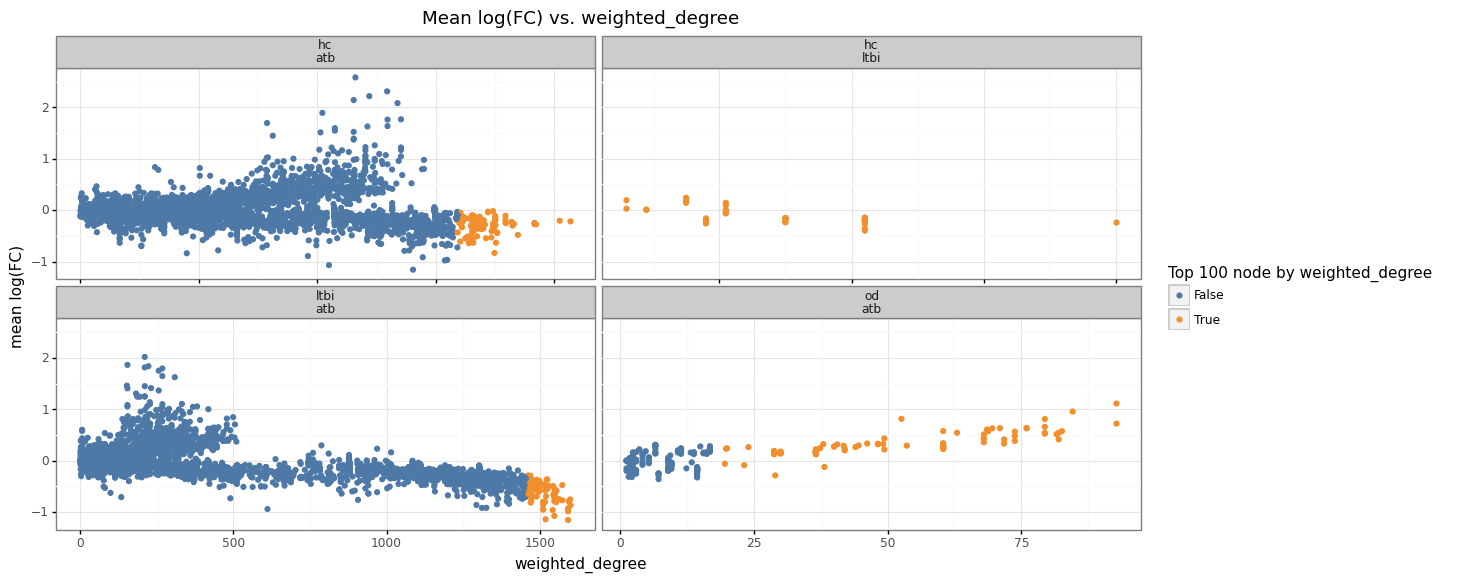

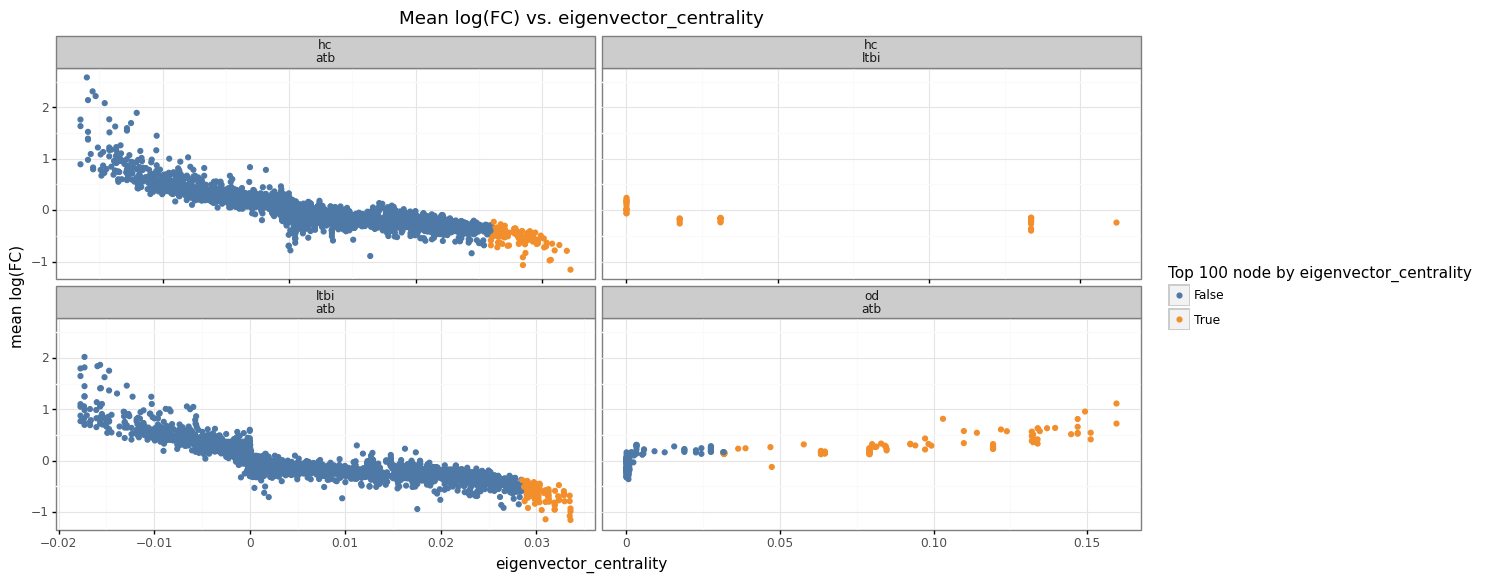

In [40]:
for measure in ['degree', 'weighted_degree', 'eigenvector_centrality']:
    tbplt.plot_mean_log_fc_vs_centrality_measure(networks, measure=measure, top_n=100).draw();

### Generate gene lists

From the constructed gene networks, generate lists of genes found in the top
100 (as measured by weighted degree) in each comparison network.

In [41]:
gene_lists = na.generate_gene_lists(networks, top_n=100)

#### Inspect network gene list intersections

`hc-atb` and `ltbi-atb` intersection:

In [42]:
updated = set(gene_lists[('hc', 'atb')]).intersection(set(gene_lists[('ltbi', 'atb')]))
print(updated)
with (project_dir / 'data' / 'hc_atb_and_ltbi_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')

{'FAM102A', 'ATP6V0E2', 'LAX1', 'SKAP1', 'DHRS3', 'ST6GALNAC6', 'SLFN5', 'SPIB', 'ATP8B2', 'GPR183', 'LTBP3', 'IFNLR1', 'TSEN54', 'SLC4A7', 'P2RY10'}


`hc-atb`, `ltbi-atb`, and `od-atb` intersection:

In [43]:
updated = set(gene_lists[('hc', 'atb')]).intersection(set(gene_lists[('ltbi', 'atb')]), set(gene_lists[('od', 'atb')]))
with (project_dir / 'data' / 'hc_atb_and_ltbi_atb_and_od_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')
with (project_dir / 'data' / 'roger_top_genes_all_networks.txt').open('r') as f:
    roger = set([x.strip() for x in f.readlines()])
print('Updated: ', updated)
print('Roger: ', roger)
print('Updated and Roger intersection: ', updated.intersection(roger))

Updated:  set()
Roger:  {'EPSTI1', 'IFIT3', 'IFITM3', 'ANXA3', 'C1QB', 'PSTPIP2', 'BATF2', 'TLR5', 'ANKRD22', 'DUSP3', 'GBP5', 'GBP1', 'FCGR1B', 'VAMP5', 'SMARCD3', 'CEACAM1', 'LAP3', 'WARS', 'GBP4', 'FAM26F', 'SERPING1', 'XAF1', 'ADM', 'AIM2'}
Updated and Roger intersection:  set()


`hc-atb`, `ltbi-atb`, but not `od-atb`:

In [44]:
updated = set(gene_lists[('hc', 'atb')]).intersection(set(gene_lists[('ltbi', 'atb')])) - set(gene_lists[('od', 'atb')])
with (project_dir / 'data' / 'hc_atb_and_ltbi_atb_not_od_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')
with (project_dir / 'data' / 'roger_top_genes_not_in_od_network.txt').open('r') as f:
    roger = [x.strip() for x in f.readlines()]
print('Updated: ', updated)
print('Roger: ', roger)
print('Updated and Roger intersection: ', updated.intersection(roger))

Updated:  {'SLC4A7', 'FAM102A', 'ATP6V0E2', 'LAX1', 'SKAP1', 'DHRS3', 'ST6GALNAC6', 'SLFN5', 'SPIB', 'ATP8B2', 'GPR183', 'IFNLR1', 'TSEN54', 'LTBP3', 'P2RY10'}
Roger:  ['TNFSF10', 'DYSF', 'IL1B', 'GK', 'LHFPL2', 'TRIM22', 'CLEC4D', 'TNFSF13B', 'PLAUR', 'LY96', 'FBXO6', 'KCNJ15', 'SPOCK2', 'TMEM204', 'IL7R', 'GPR183', 'ID3', 'CD6', 'KLRB1', 'PIK3IP1', 'CCR7', 'NELL2', 'SKAP1']
Updated and Roger intersection:  {'SKAP1', 'GPR183'}


### Plot effect size heatmaps across gene sets and comparison networks

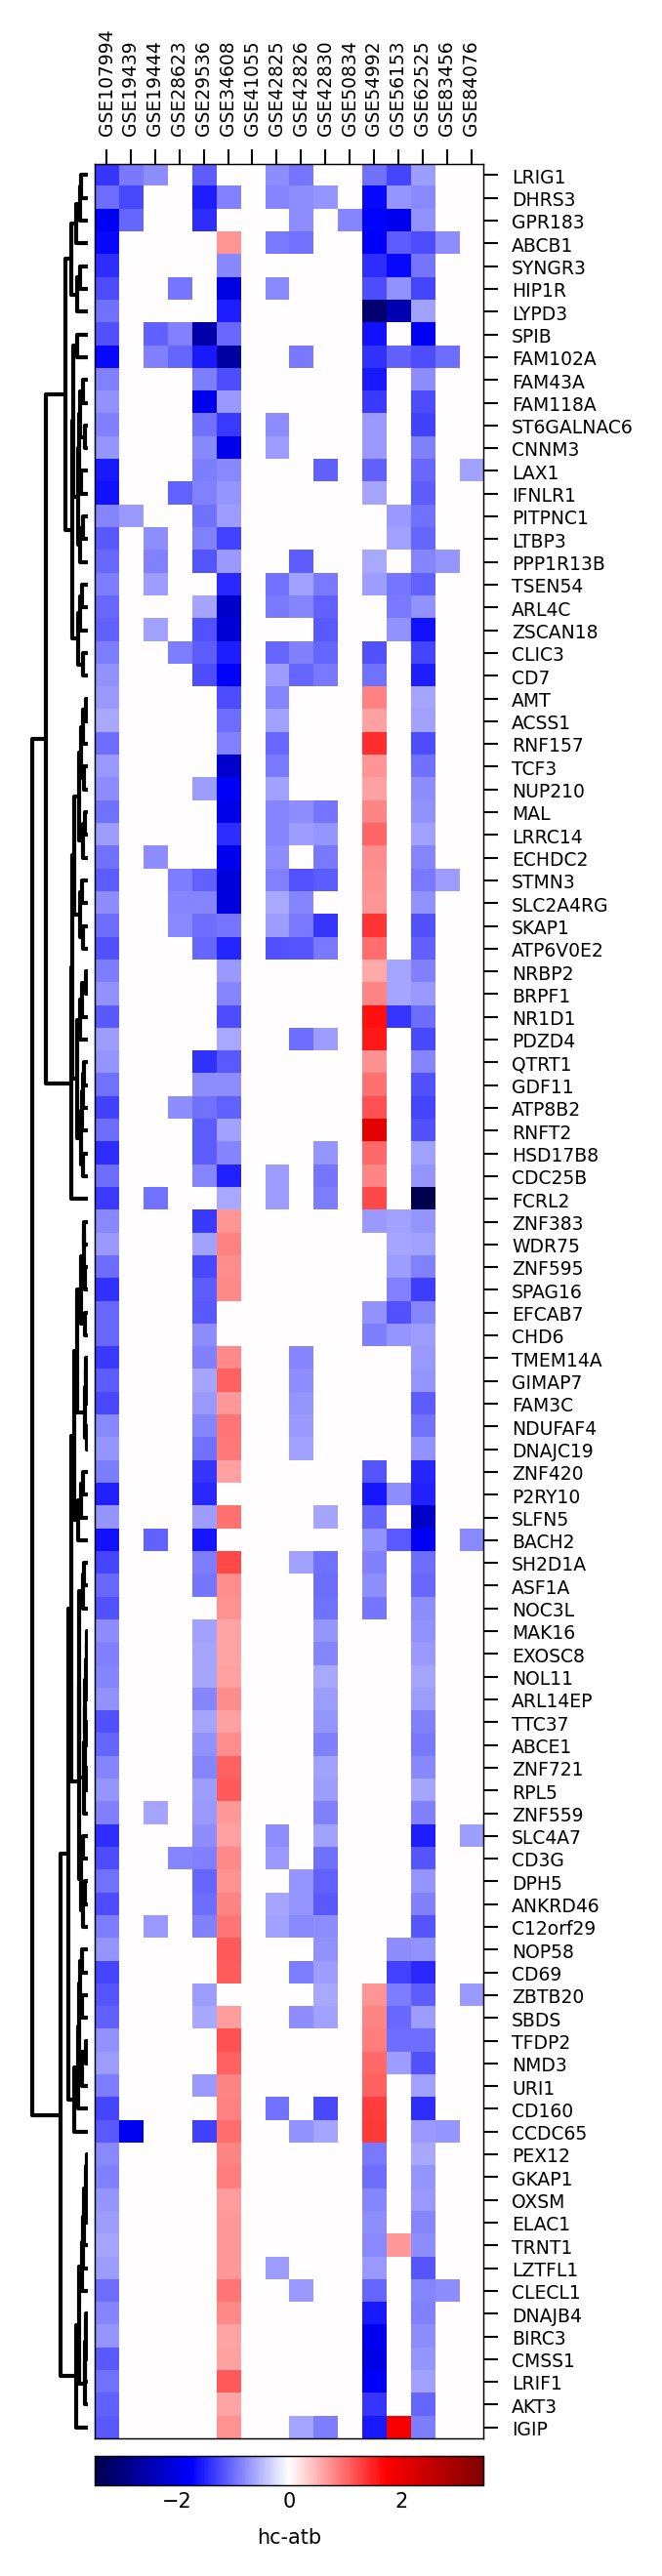

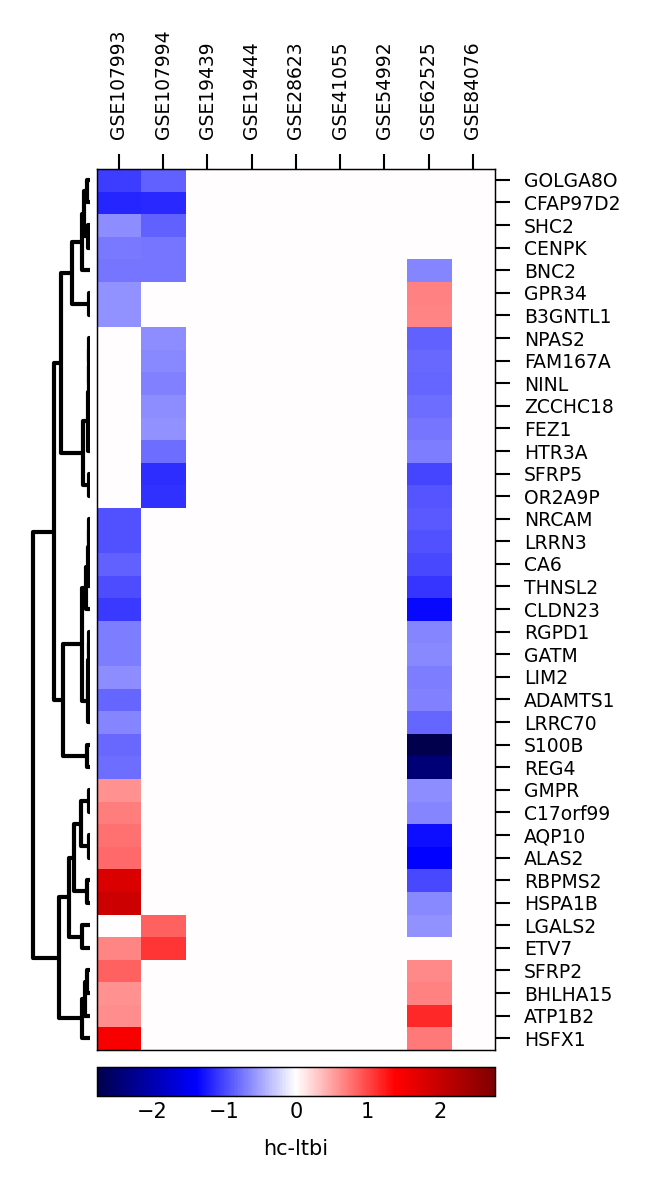

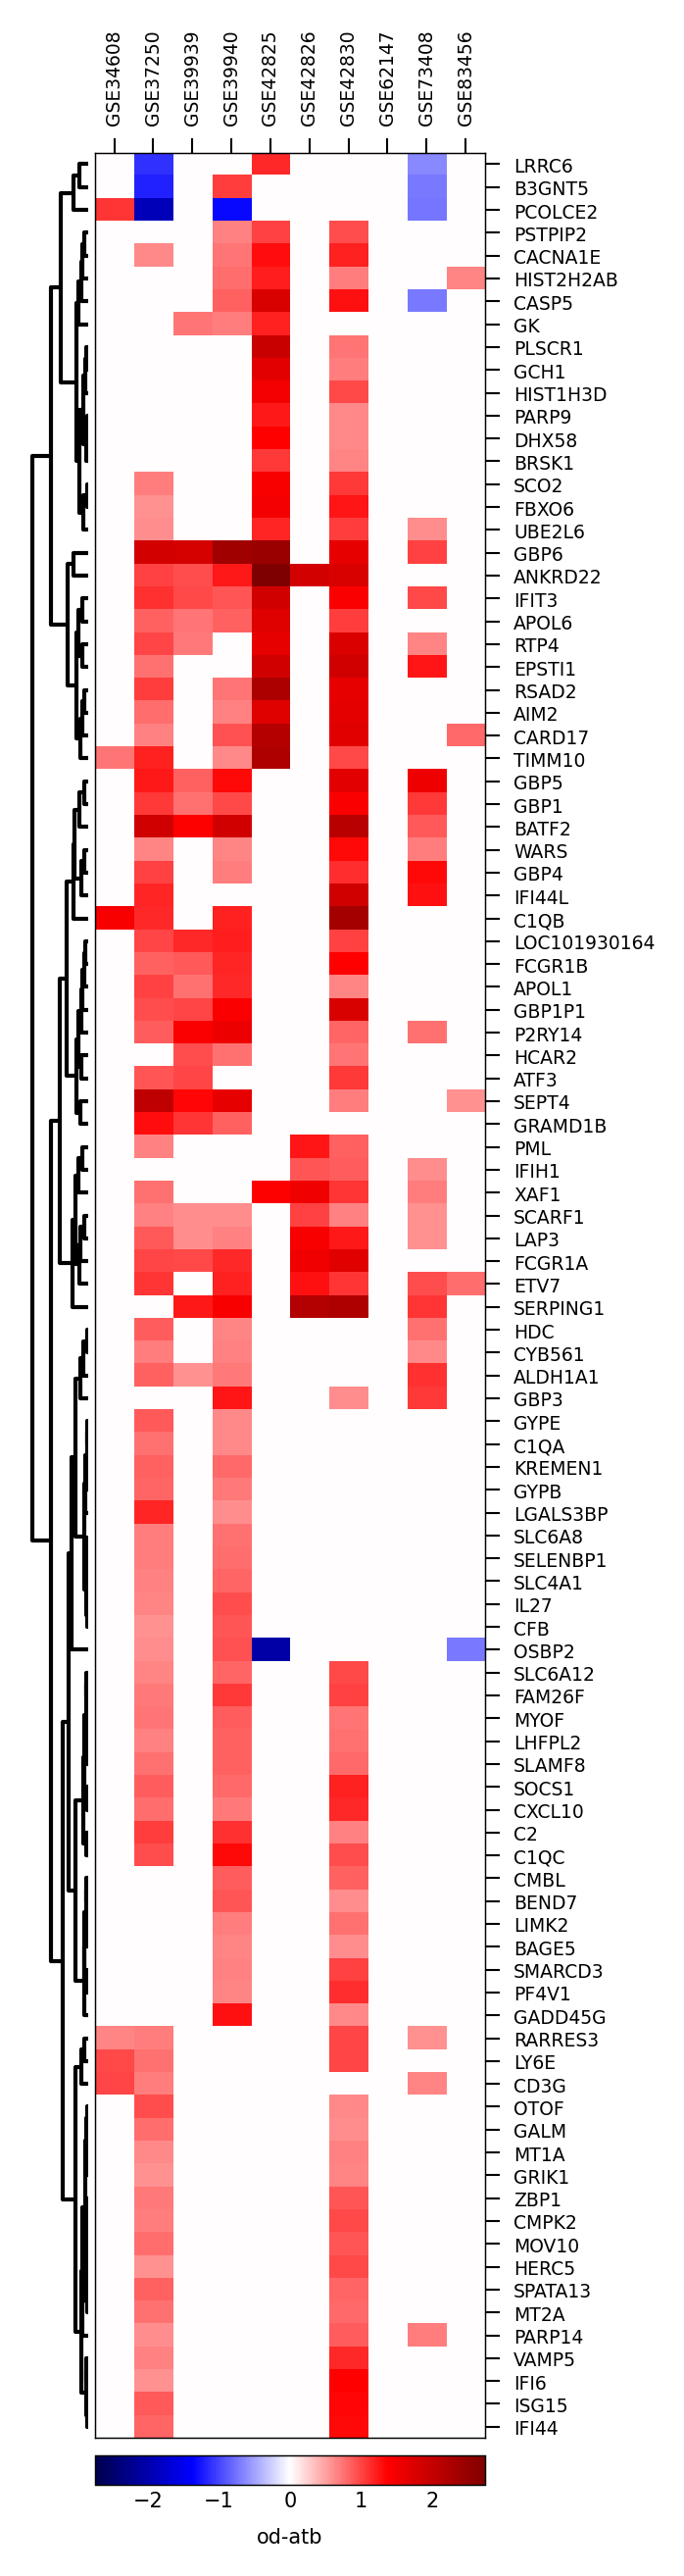

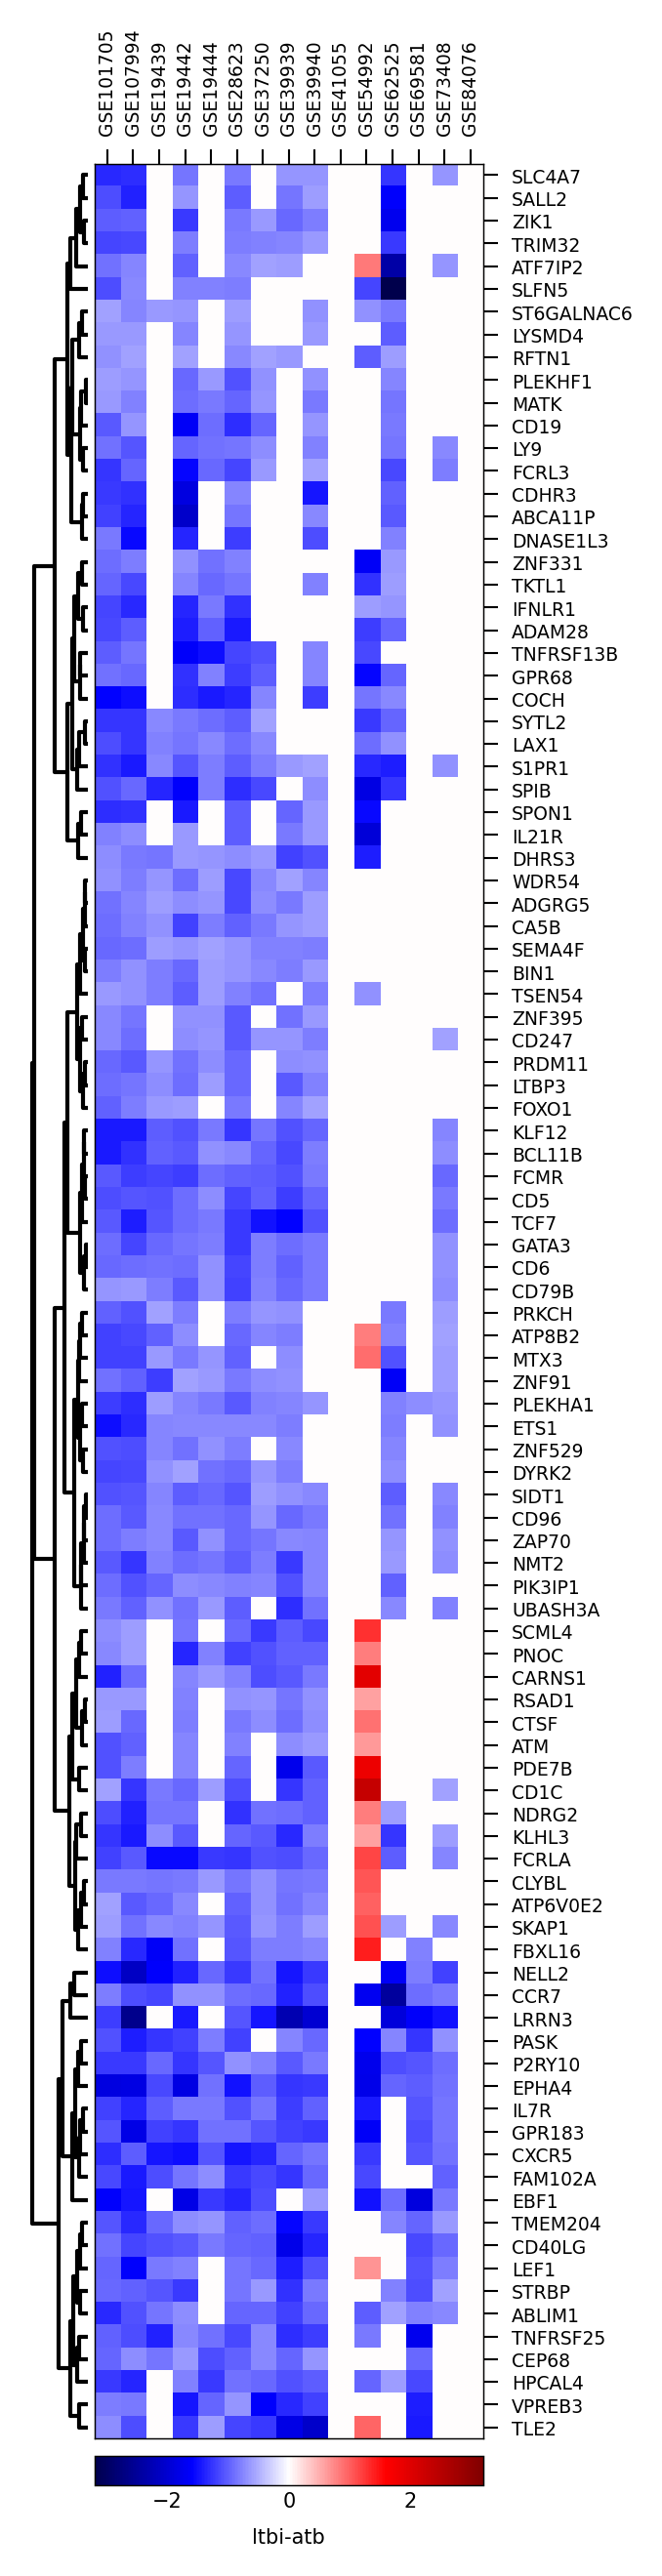

In [45]:
for (control, case), df in merged_results.items():
    tbplt.plot_log_fc_heatmap(
        df, gene_set=gene_lists[(control, case)], control=control, case=case)